# ПРОГНОЗИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ НА ОСНОВЕ МЕТОДА SSA – «ГУСЕНИЦА»

__Вариант 6__

Декомпозиция ВР вида лин. тренд + НЧ гармоника + ВЧ гармоника.

In [124]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import h5py
import random
%matplotlib inline
%config InlineBackend.figure_format ='retina'

## Задание временного ряда

In [3]:
def create_linspace(start, stop, nsamples):
    return np.linspace(start, stop, num = nsamples)

def plot(X, t = [], title = '', f_dict = {}):
    """
    f_dict = {
        'functions': [F1, F2, F3],
        'titles': ['function name', 'f name 2']
    }
    """
    plt.figure(figsize = (15, 6))
    plt.title(title)
    if len(t):
        plt.plot(t, X)
    else: plt.plot(X)
    if len(f_dict) > 0:
        legend_labels = []
        for f in f_dict["functions"]:
                if len(t):
                    plt.plot(t, f)
                else: plt.plot(f)
        for label in f_dict["titles"]:
            legend_labels.append(label)
        plt.legend(['Origin', *legend_labels])
    plt.show()

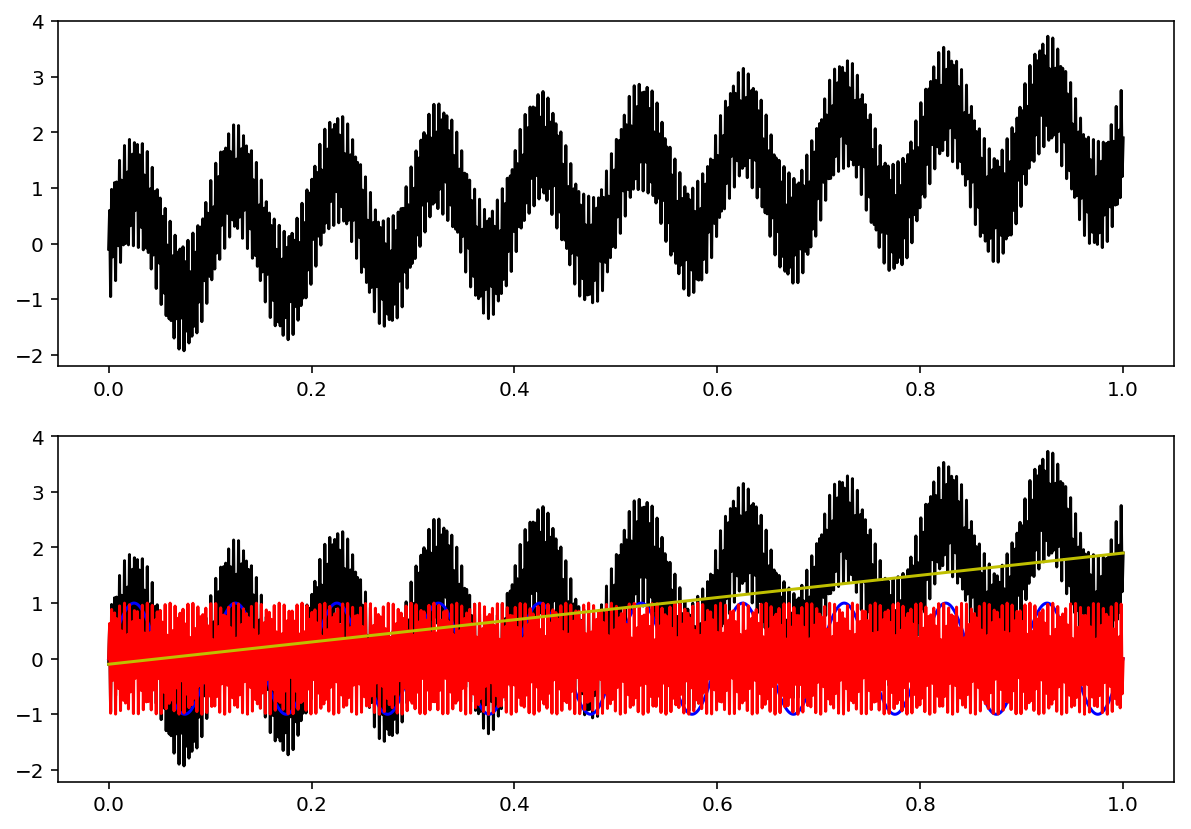

In [110]:
t = create_linspace(0, 1, 1024)

f1 = 10 # НЧ частота
f2 = 400 # ВЧ частота
component1 = np.sin(2*np.pi*f1*t)
component2 = np.sin(2*np.pi*f2*t)
component3 = 2*t - 0.1

F = component1 + component2 + component3

N = 1024

plt.figure(figsize = (10, 7))
plt.subplot(2,1,1)
plt.plot(t, F, 'k')
plt.subplot(2,1,2)
plt.plot(t, F, 'k')
plt.plot(t, component1, 'b')
plt.plot(t, component2, 'r')
plt.plot(t, component3, 'y')

plt.show()

## Метод сингулярного спектрального анализа (SSA)

In [5]:
def SSA_modes(F, L):
    """
    Функция для сингулярного разложения временного ряда
    F - Временной ряд, L - Длина окна
    """
    N = len(F)
    K = N - L + 1
    X = np.empty((L, K))
    
    for i in range(0,L):
        for j in range(0,K):
            X[i, j] = F[i + j]

    S = np.dot(X, X.T)
    U, A, _ = np.linalg.svd(S)
    V = np.dot(X.T, U)
    return A, U, V

def SSA_group(A, U, V, N, I):
    """
    Функция для восстановления ряда
    Входные параметры: 
    массив собственных значений A, 
    массив собственных векторов U, 
    массив траекторных векторов V, 
    длина ряда N и массив группировки компонент I.
    """
    L = len(A)
    K = N - L + 1
    V = V.transpose()
    Z = np.dot(U[:, I], V[I, :])

    G = np.zeros(N)
    L_min = min(L,K)
    K_max = max(L,K)
    
    for k in range(N):
        if (0 <= k < L_min - 1):
            sum_Z = Z[0, k]
            
            for m in range(k):
                sum_Z += Z[m, k-m]
            G[k] = 1 / (k + 1) * sum_Z
            
        if (L_min - 1 <= k < K_max):
            sum_Z = Z[0, k]
            
            for m in range(L_min - 1):
                sum_Z += Z[m, k-m]
            G[k] = 1 / L_min * sum_Z
            
        if (K_max <= k < N + 1):
            sum_Z = Z[k - K_max + 1, 0]
            
            for m in range(k - K_max + 1, N - K_max):
                sum_Z += Z[m, k-m]
                
            if (k - K_max + 1 == N - K_max):
                sum_Z = Z[k - K_max + 1, N - K_max]
            G[k] = 1 / (N - k) * sum_Z
            
    return G

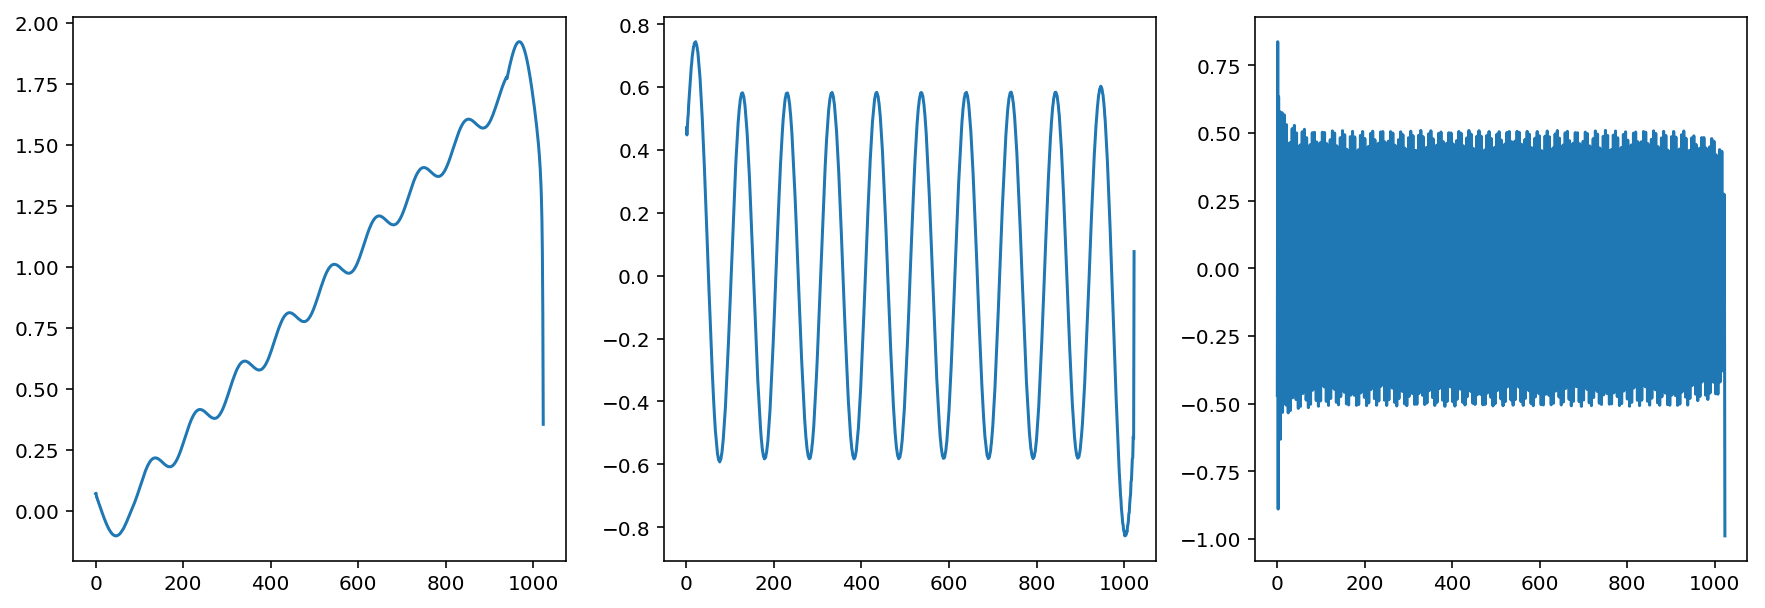

In [111]:
L = 85 # Длина окна

A, U, V = SSA_modes(F, L)

plt.figure(figsize=(15,5))
F1_1 = SSA_group(A, U, V, len(F),  [0])
plt.subplot(1,3,1)
plt.plot(F1_1)
F1_2 = SSA_group(A, U, V, len(F),  [1])
plt.subplot(1,3,2)
plt.plot(F1_2)
F1_3 = SSA_group(A, U, V, len(F),  [2])
plt.subplot(1,3,3)
plt.plot(F1_3)
plt.show()

<Figure size 720x360 with 0 Axes>

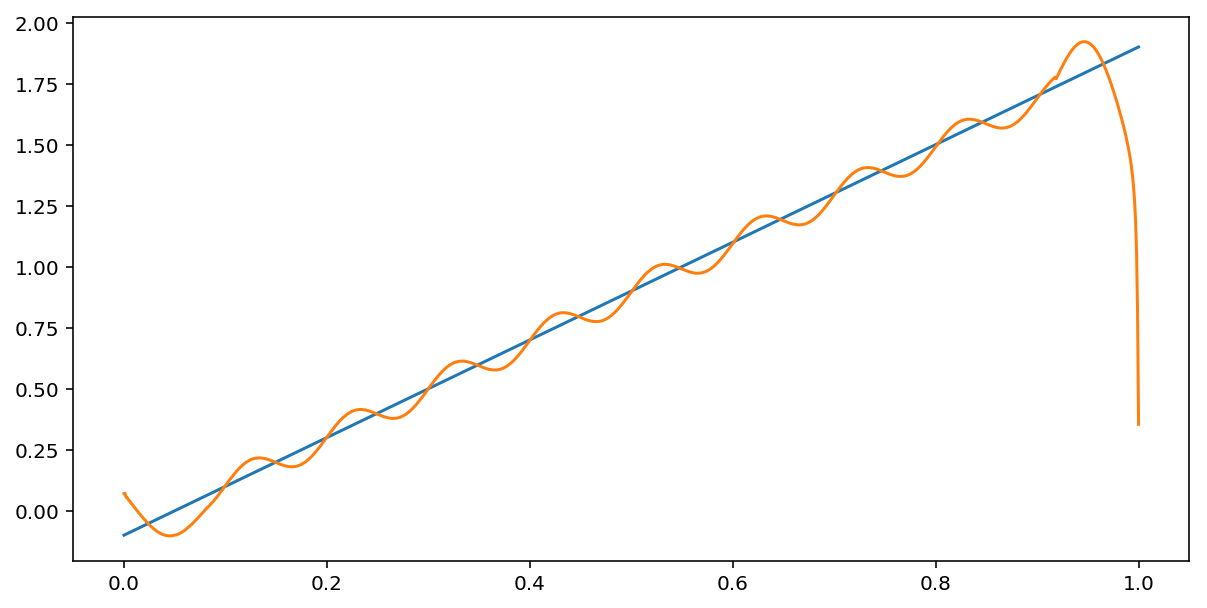

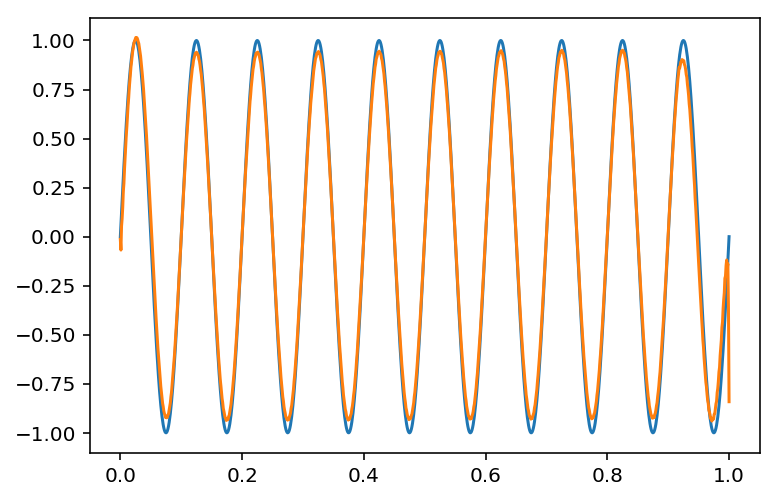

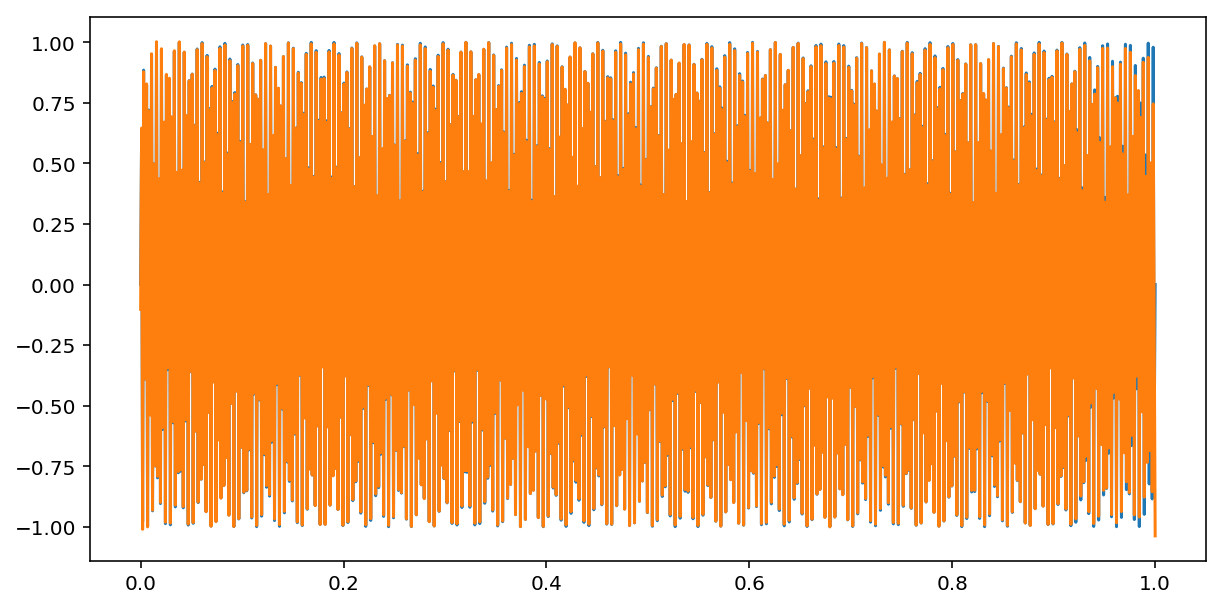

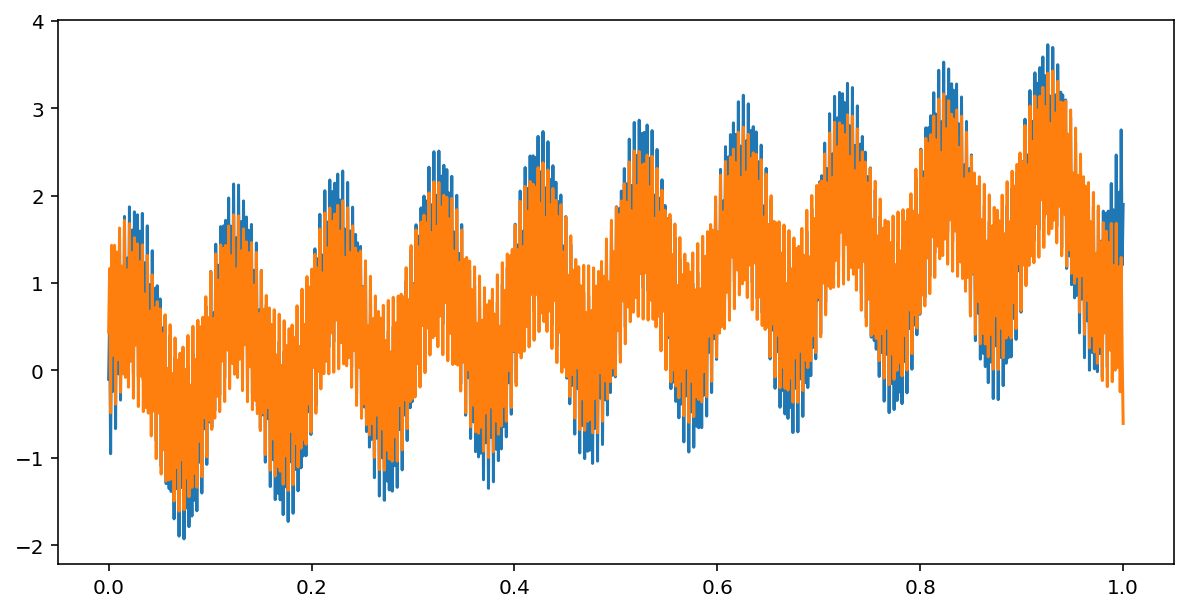

In [112]:
plt.figure(figsize = (10, 5))

plt.figure(figsize = (10, 5))
I = [0]
F1 = SSA_group(A, U, V, len(F), I)
plt.plot(t, component3)
plt.plot(t,F1)
plt.show()

I = [4,1]
F2 = SSA_group(A, U, V, len(F), I)
plt.plot(t, component1)
plt.plot(t,F2)
plt.show()

plt.figure(figsize = (10, 5))
I = [2,3]
F3 = SSA_group(A, U, V, len(F), I)
plt.plot(t, component2)
plt.plot(t,F3)
plt.show()

plt.figure(figsize = (10, 5))
I = [0,1,2,3]
F1 = SSA_group(A, U, V, len(F), I)
plt.plot(t, F)
plt.plot(t,F1)
plt.show()

### Пробуем SSA-R

4) норма последнего вектора из матрицы

In [153]:
vu = np.linalg.norm(U[-1, I])

5) ряд весовых коэффициентов

In [154]:
R = np.sum(U[L - 1, I] * U[0:L - 1, I], 1)
R = R / (1 - vu * vu)

IndexError: index 225 is out of bounds for axis 0 with size 85

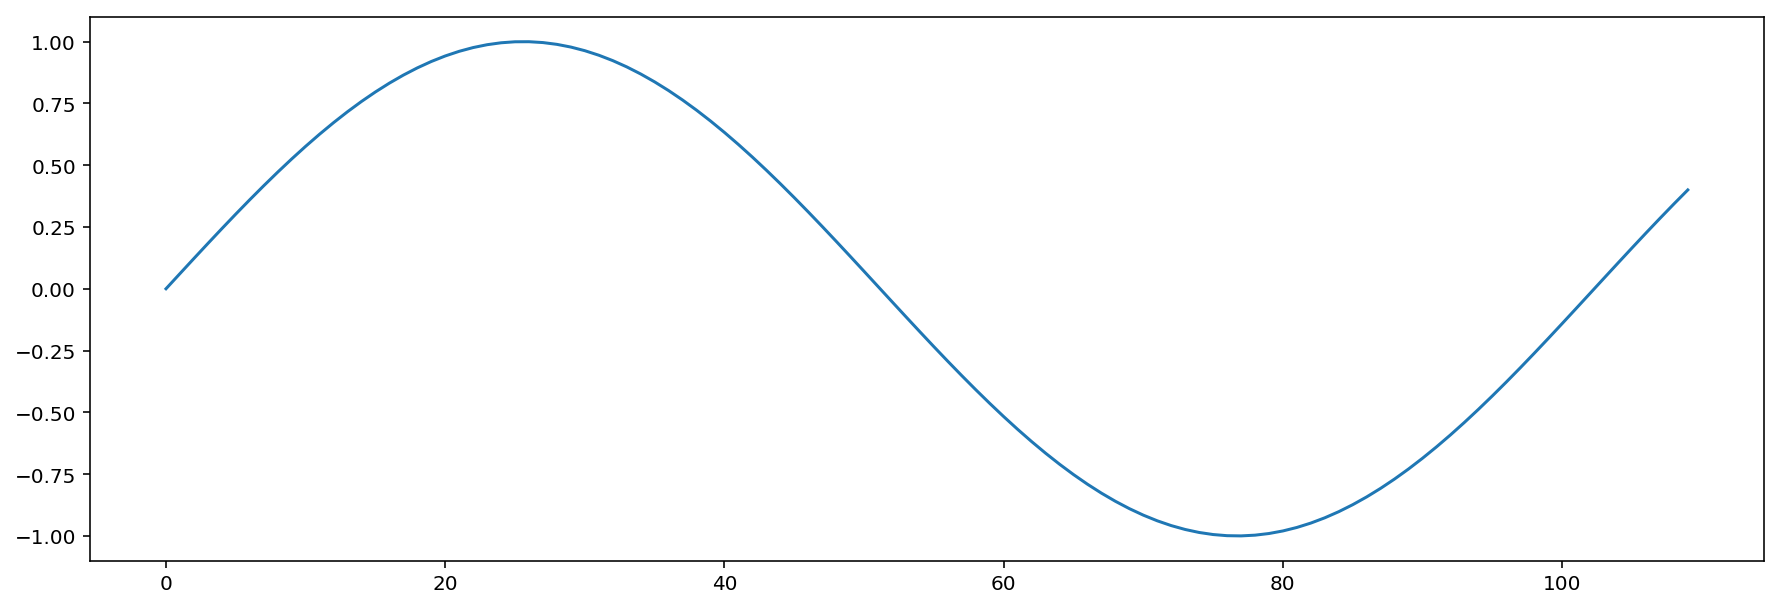

In [155]:
M = 110 # Прогноз строится на M точек вперед

plt.figure(figsize = (15, 5))
plt.plot(component1[0:M], label='S');

In [156]:
def SSA_R(F, N, L, M, I):
    A, U, V = SSA_modes(F, L)
    vu = np.linalg.norm(U[-1, I])
    R = np.sum(U[L - 1, I] * U[0:L - 1, I], 1)
    R = R / (1 - vu * vu)
    Q = F 
    for i in range(N, N + M): 
        ag = [] 
        for j in range(0, L-2): 
            ag.append(R[j] * Q[i-j-1]) 
        Q = np.append(Q, sum(ag))
    return Q

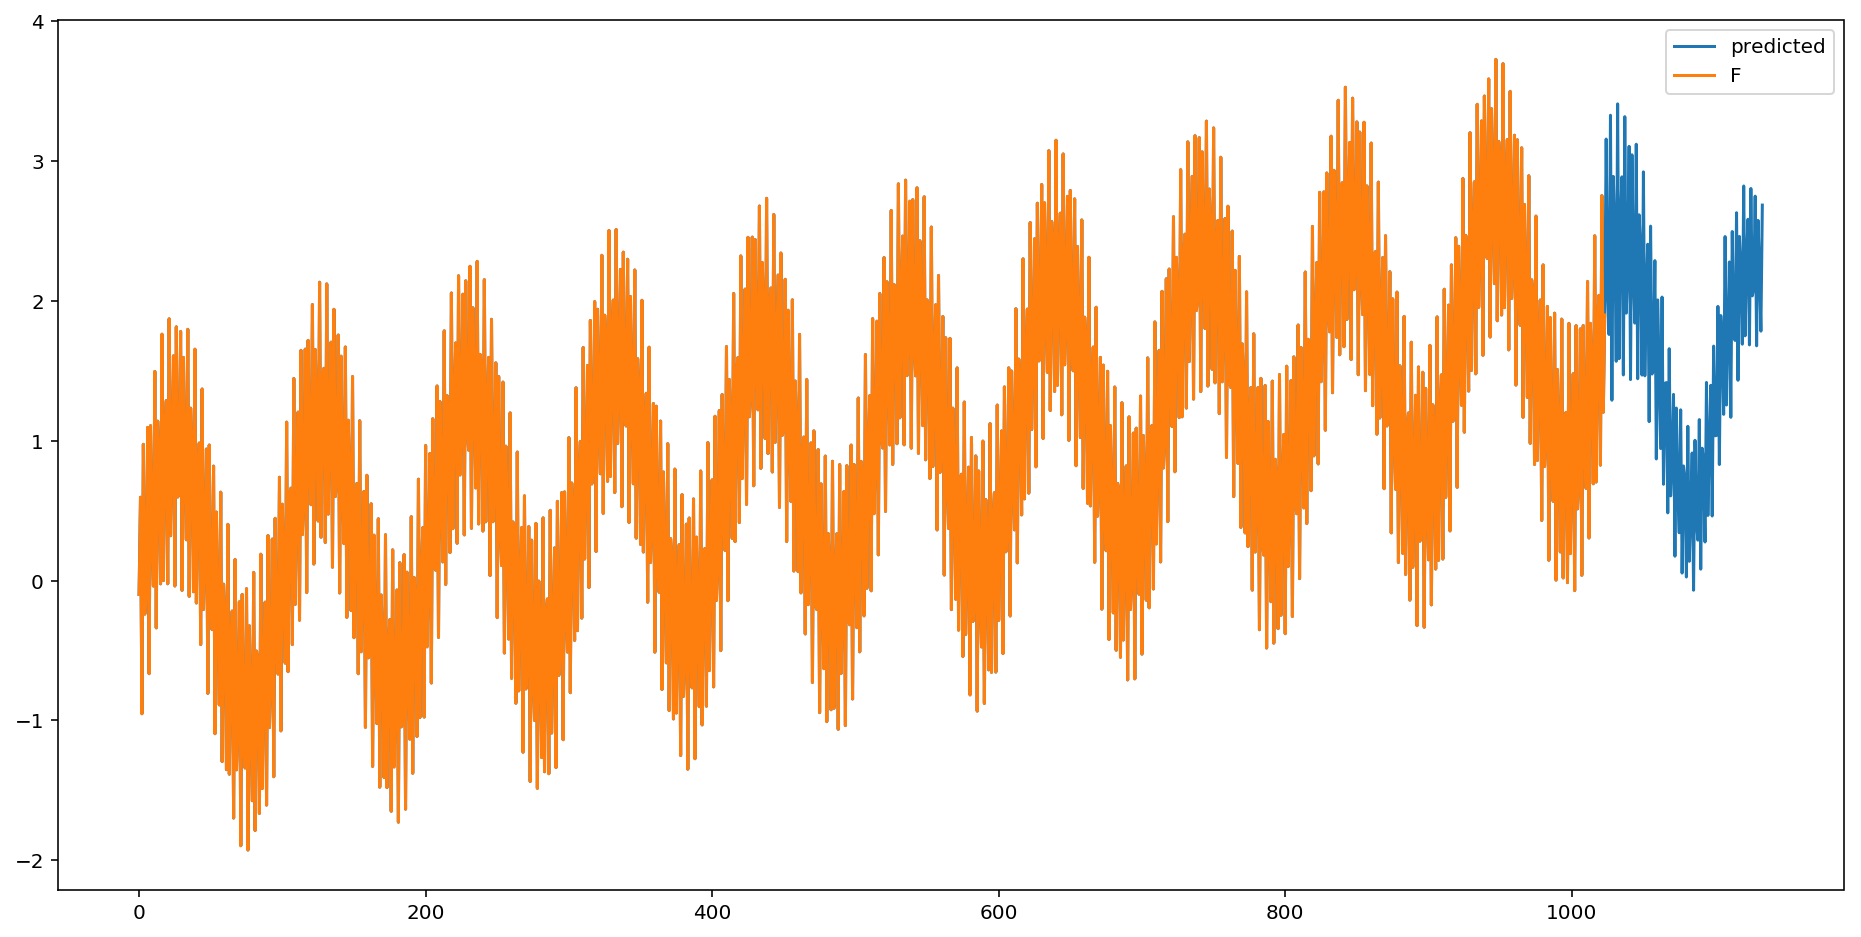

In [157]:
I = [0,1,2,3,4,5]
N_part = N 
F_part = F[:N_part]
MAE = []

L = 85

Q = SSA_R(F_part, N_part, L, M, I)
plt.figure(figsize=(16, 8))
plt.plot(Q, label='predicted')
plt.plot(F, label='F')


plt.legend()
plt.show()

### SSA_S

Определен ниже

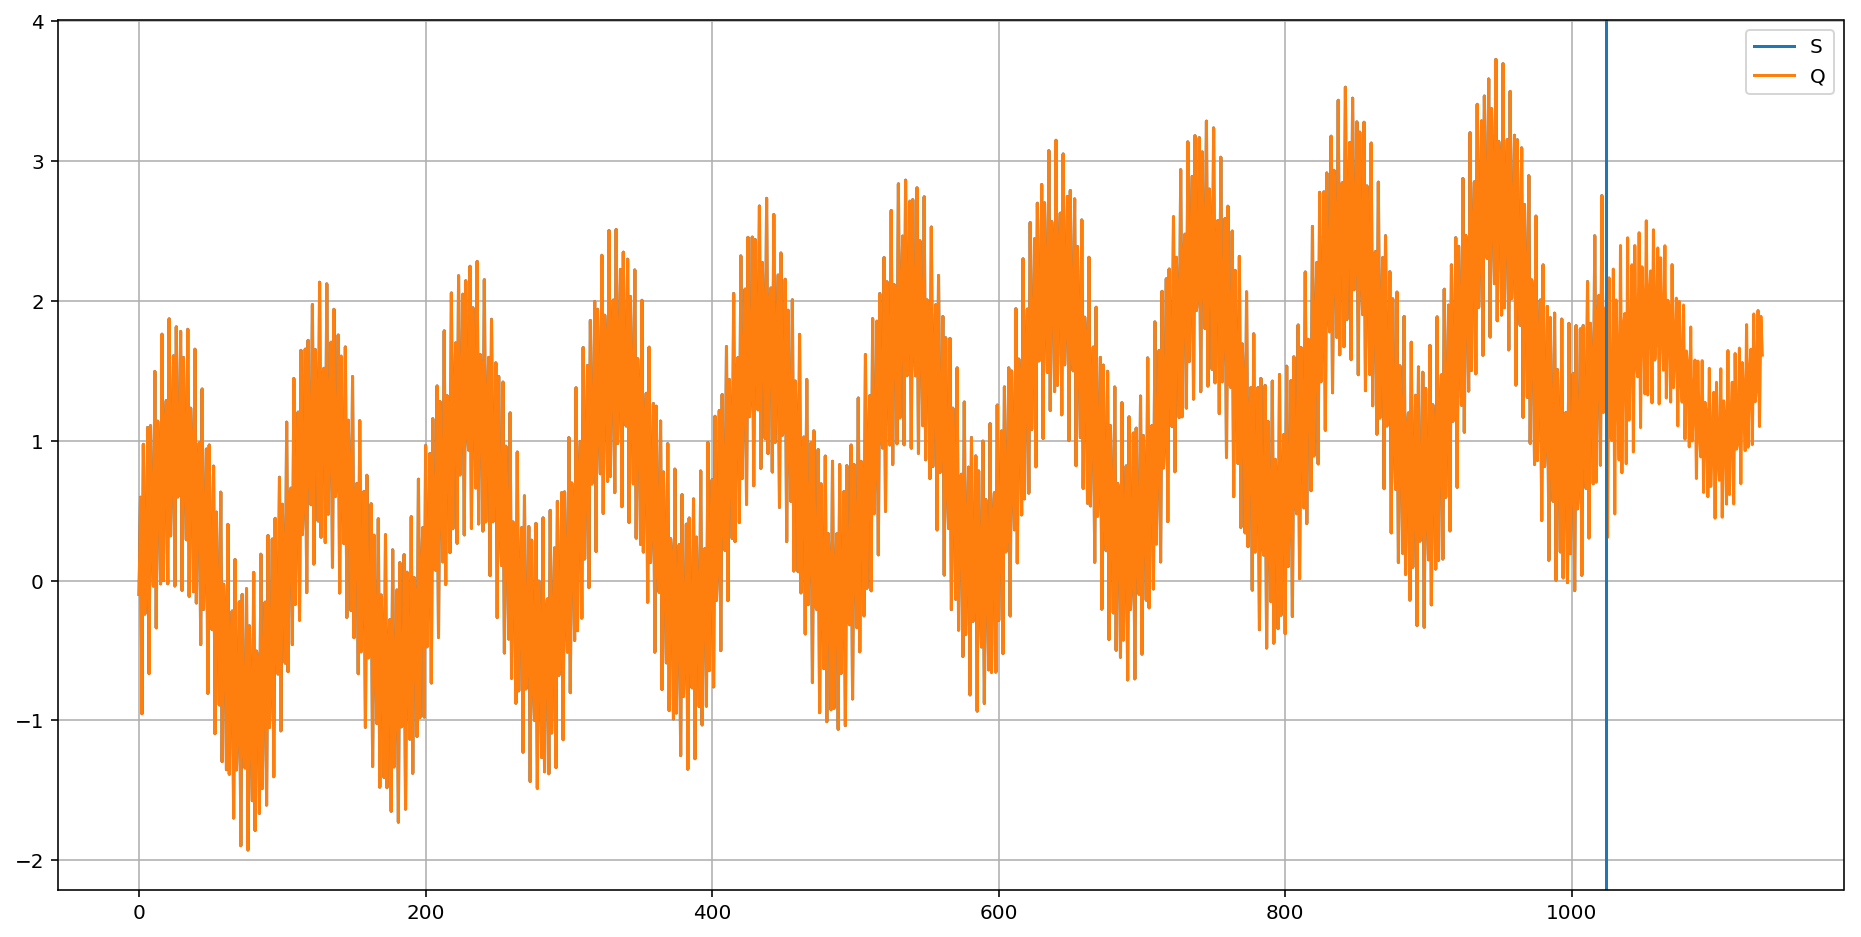

In [159]:
N_part = N
F_part = F[:N_part]
I = [0,1,2,3]
L = 85

Q = SSA_S(F_part, N_part, L, M, I)
plt.figure(figsize=(16, 8))
plt.plot(F, label = 'S')
plt.plot(Q, label = 'Q')
plt.axvline(N_part)
plt.grid()
plt.legend()
plt.show()

## Fort.mat

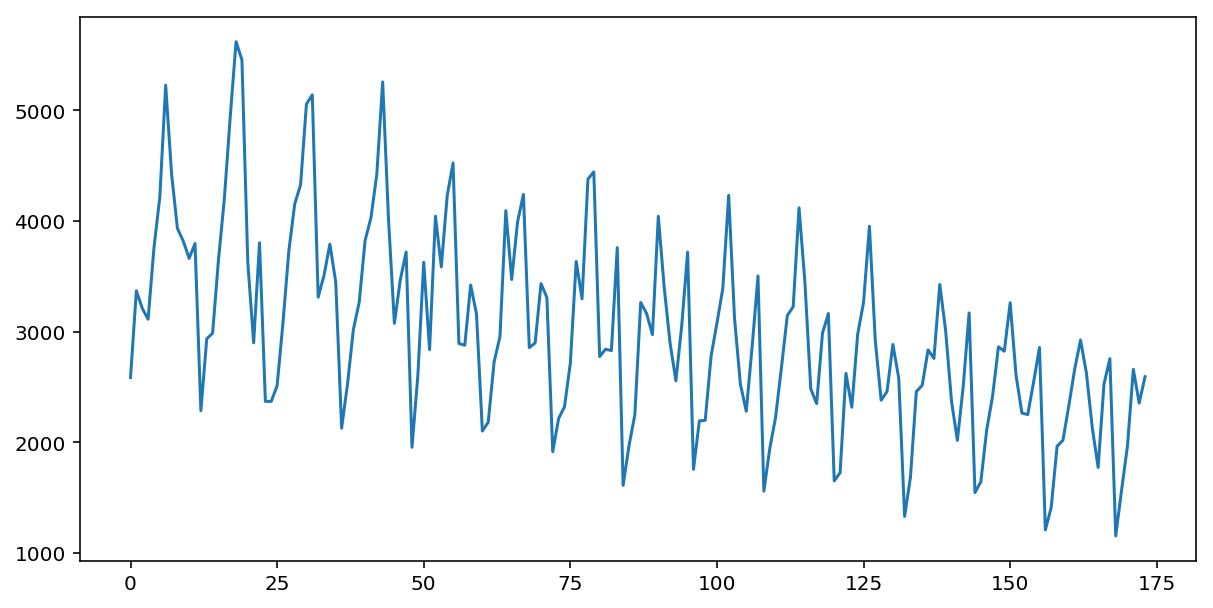

In [58]:
file = h5py.File('Fort.mat','r')
data = file.get('Fort')
fort = np.array(data)
F = np.ravel(fort)
N = len(F)
plt.figure(figsize = (10, 5))
plt.plot(F)
plt.show()

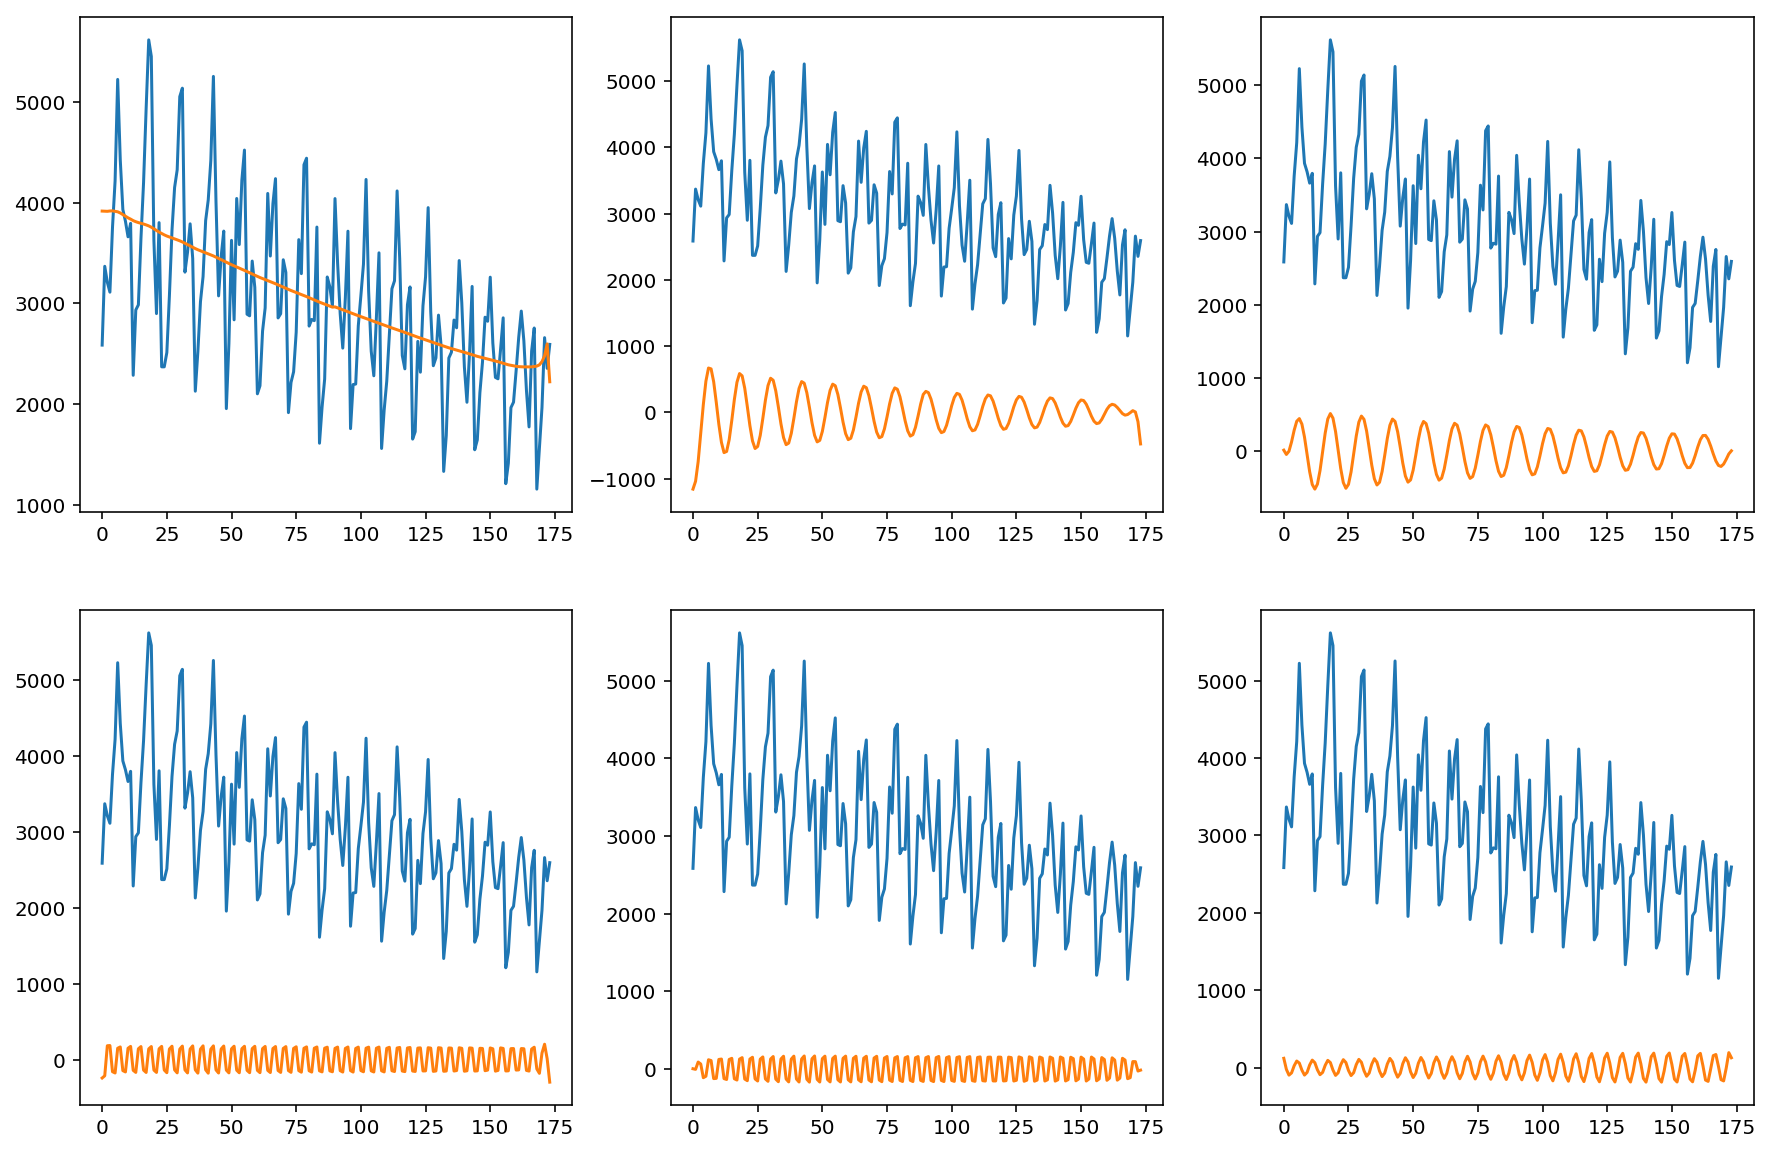

In [85]:
L = 85 # Длина окна

A, U, V = SSA_modes(F, L)

plt.figure(figsize=(15,10))
F1_1 = SSA_group(A, U, V, len(F),  [0])
plt.subplot(2,3,1)
plt.plot(F)
plt.plot(F1_1)
F1_2 = SSA_group(A, U, V, len(F),  [1])
plt.subplot(2,3,2)
plt.plot(F)
plt.plot(F1_2)
F1_3 = SSA_group(A, U, V, len(F),  [2])
plt.subplot(2,3,3)
plt.plot(F)
plt.plot(F1_3)

F2_1 = SSA_group(A, U, V, len(F),  [3])
plt.subplot(2,3,4)
plt.plot(F)
plt.plot(F2_1)
F2_2 = SSA_group(A, U, V, len(F),  [4])
plt.subplot(2,3,5)
plt.plot(F)
plt.plot(F2_2)
F2_3 = SSA_group(A, U, V, len(F),  [5])
plt.subplot(2,3,6)
plt.plot(F)
plt.plot(F2_3)
plt.show()

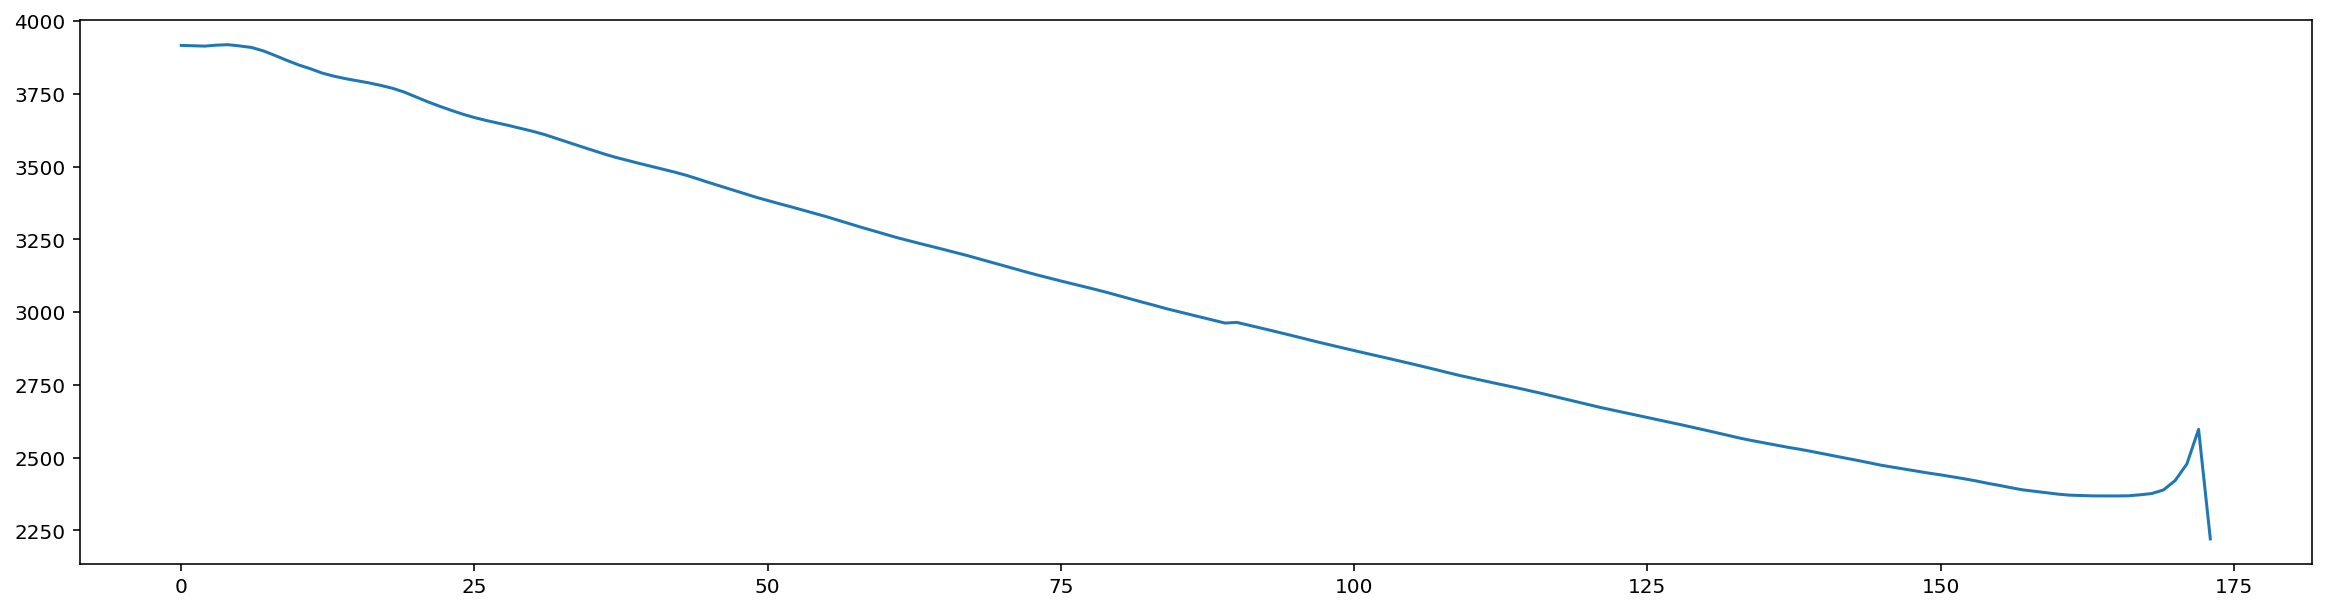

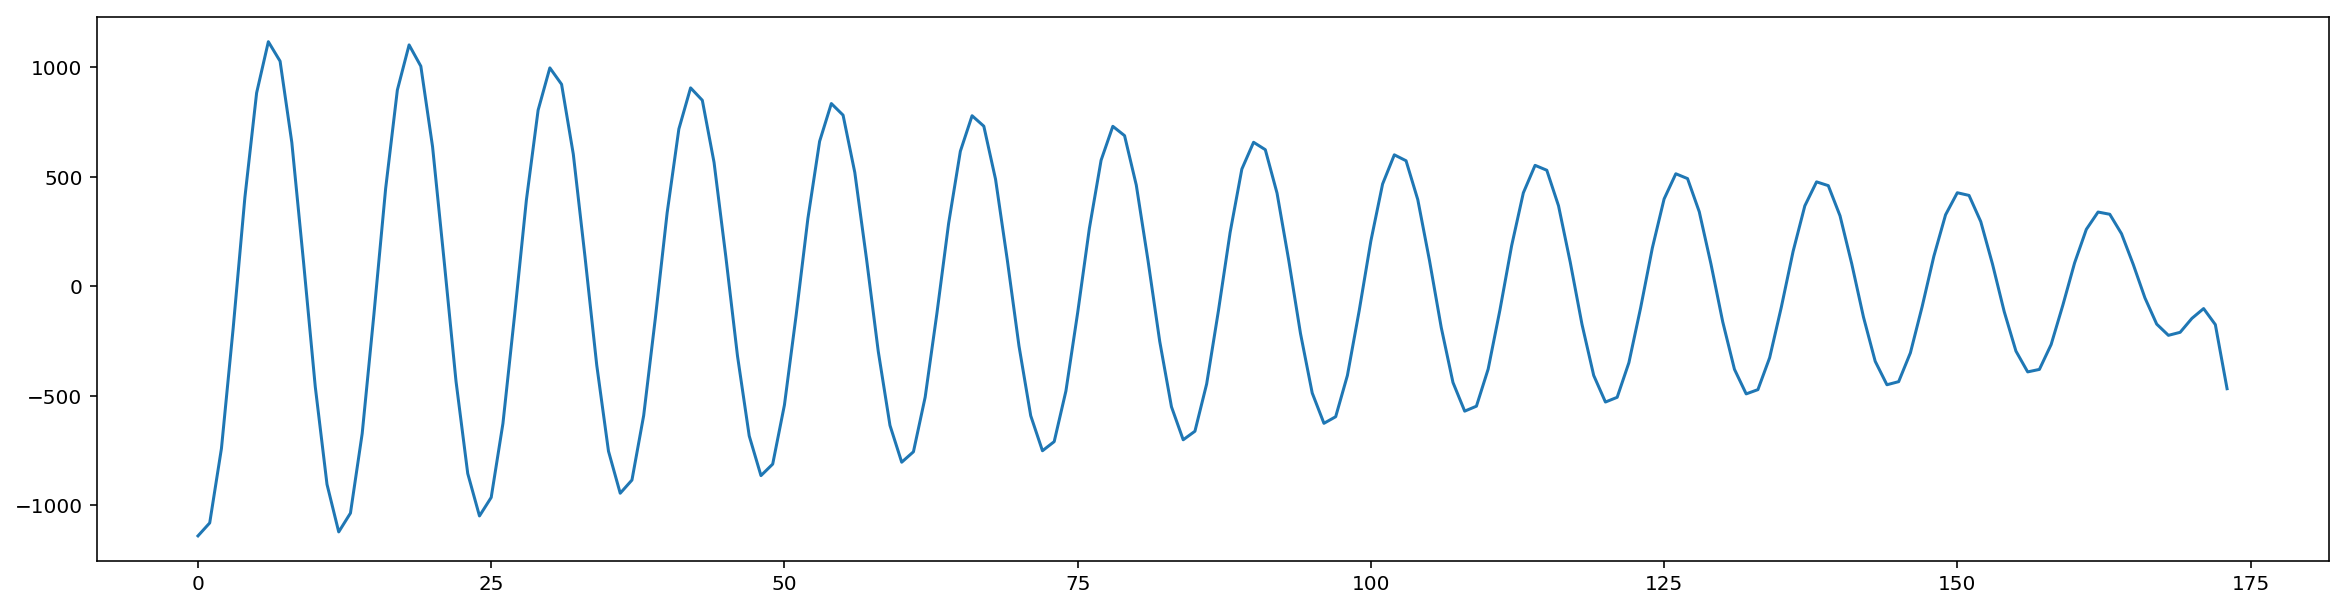

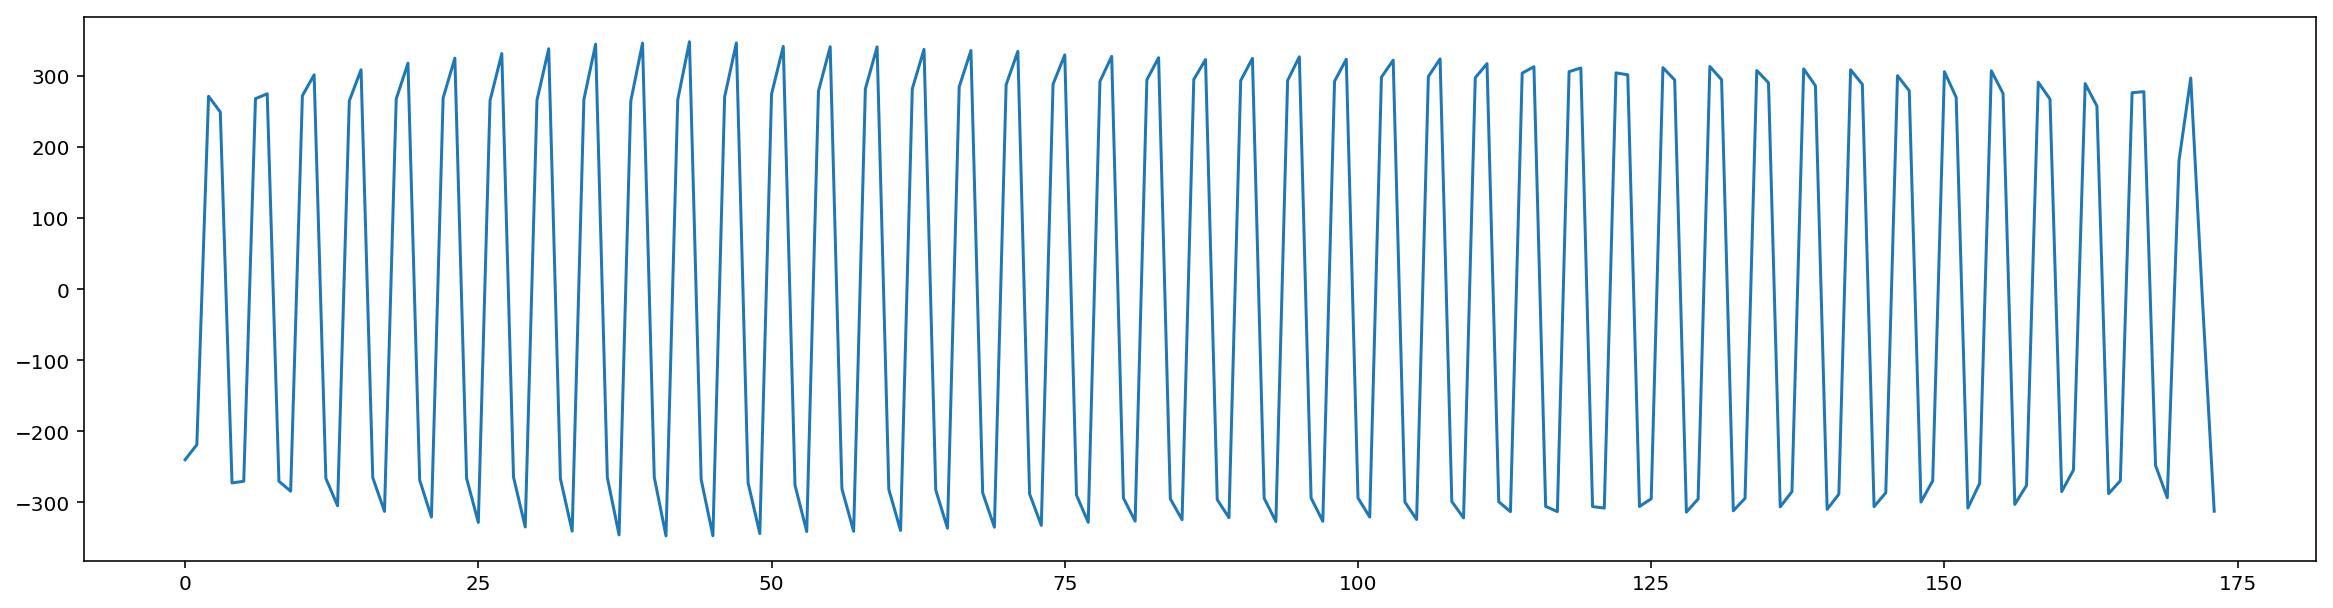

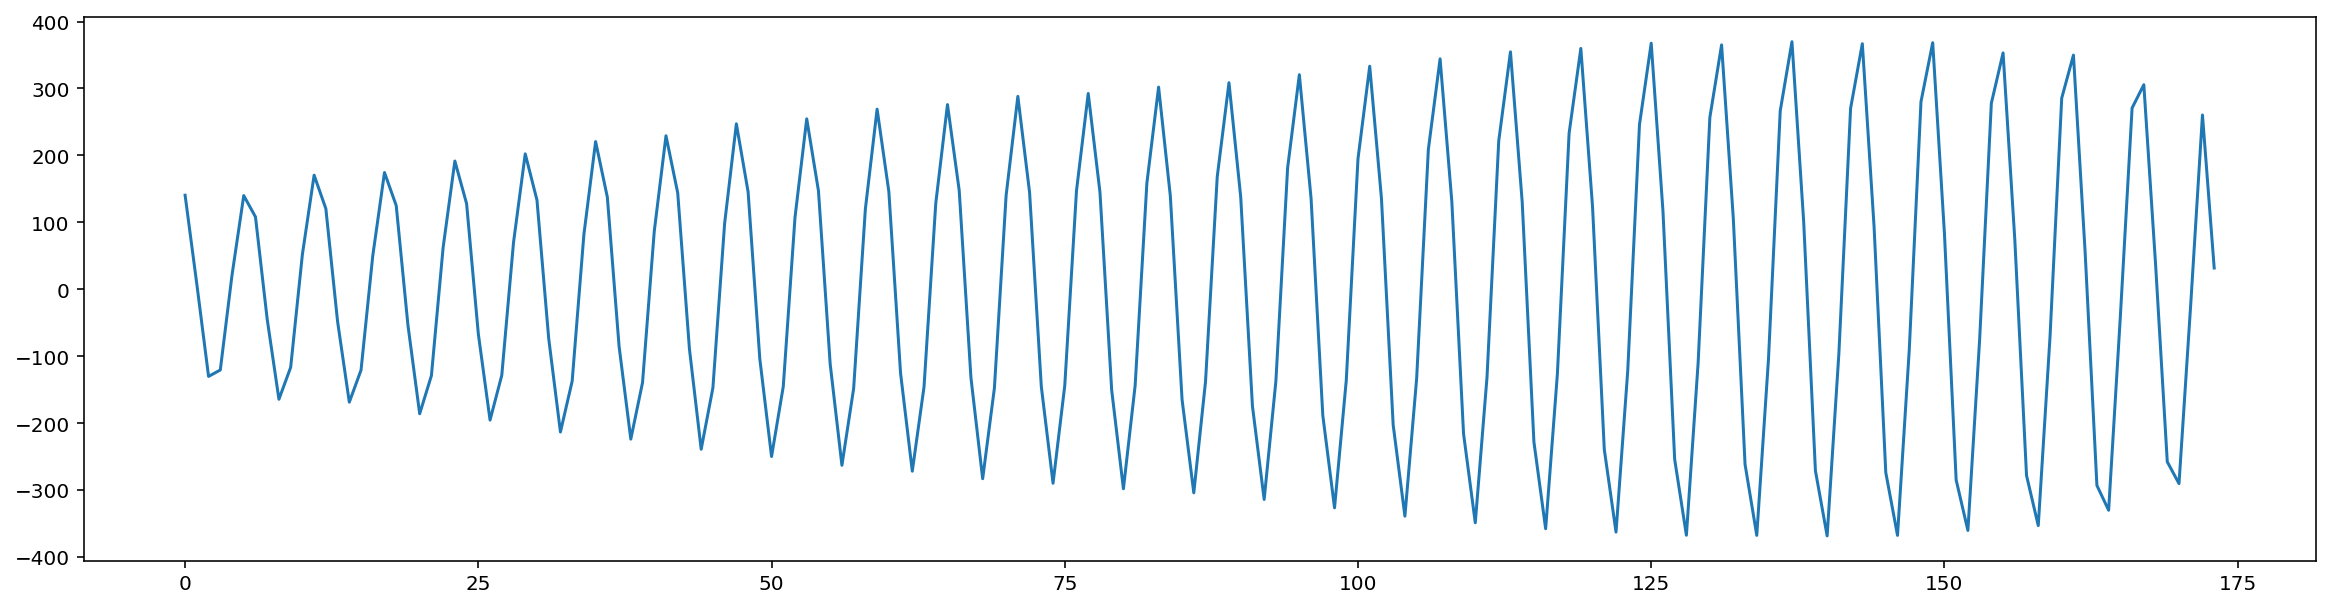

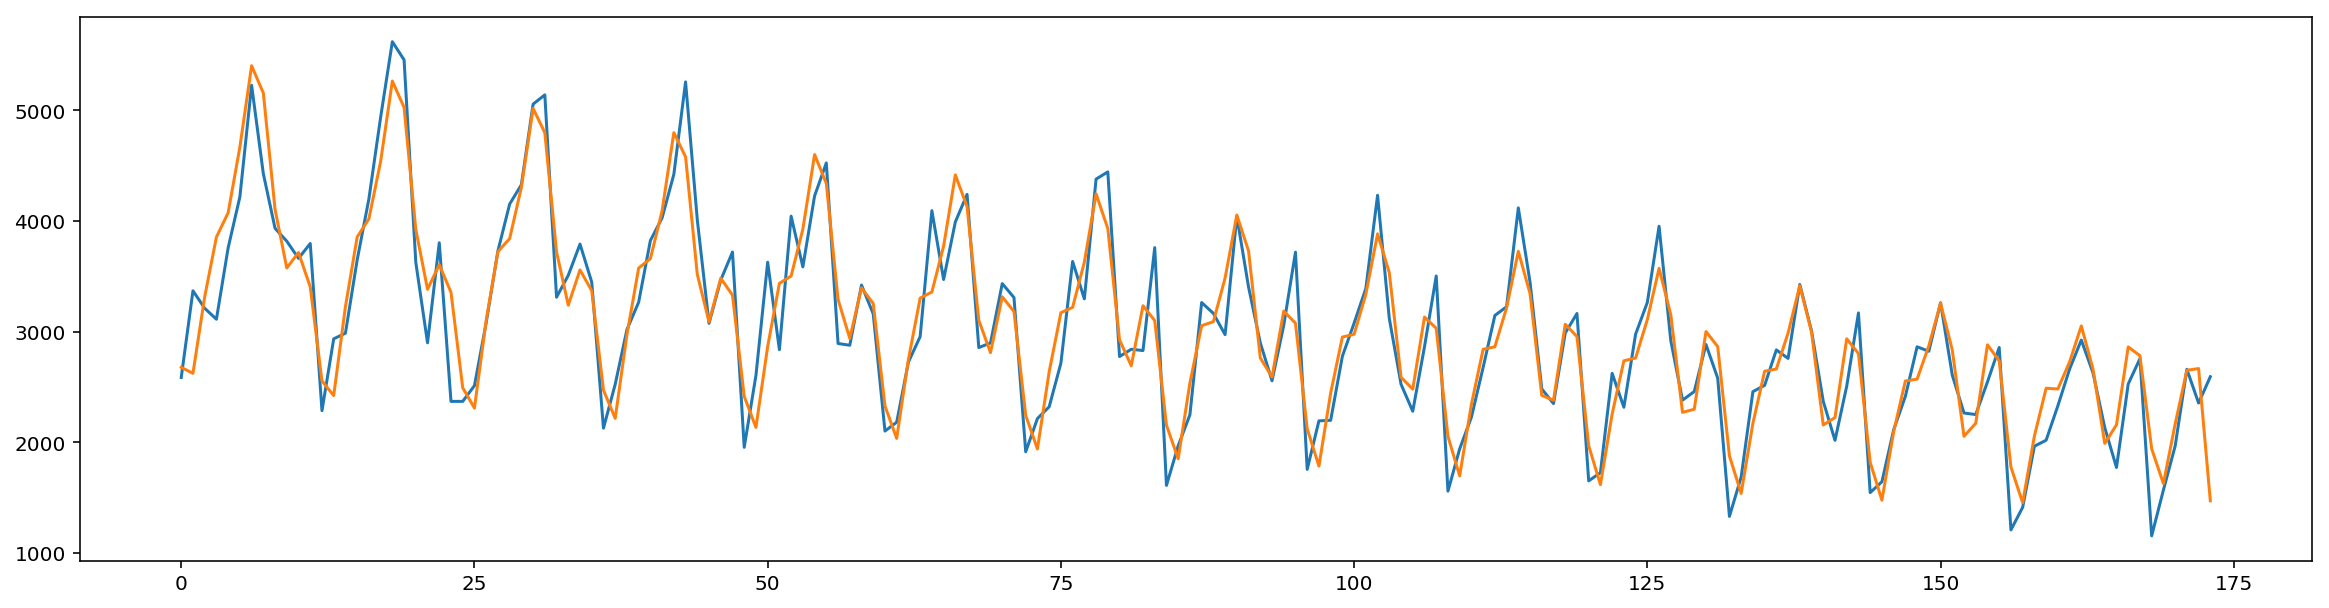

In [86]:
plt.figure(figsize = (20, 5))
I = [0]
F1 = SSA_group(A, U, V, len(F), I)
plt.plot(F1)
plt.show()

plt.figure(figsize = (20, 5))
I = [1,2]
F2 = SSA_group(A, U, V, len(F), I)
plt.plot(F2)
plt.show()

plt.figure(figsize = (20, 5))
I = [3,4]
F3 = SSA_group(A, U, V, len(F), I)
plt.plot(F3)
plt.show()

plt.figure(figsize = (20, 5))
I = [5,6]
F3 = SSA_group(A, U, V, len(F), I)
plt.plot(F3)
plt.show()

plt.figure(figsize = (20, 5))
I = [0,1,2,3,4,5,6]
F1 = SSA_group(A, U, V, len(F), I)
plt.plot(F)
plt.plot(F1)
plt.show()

### SSA_R

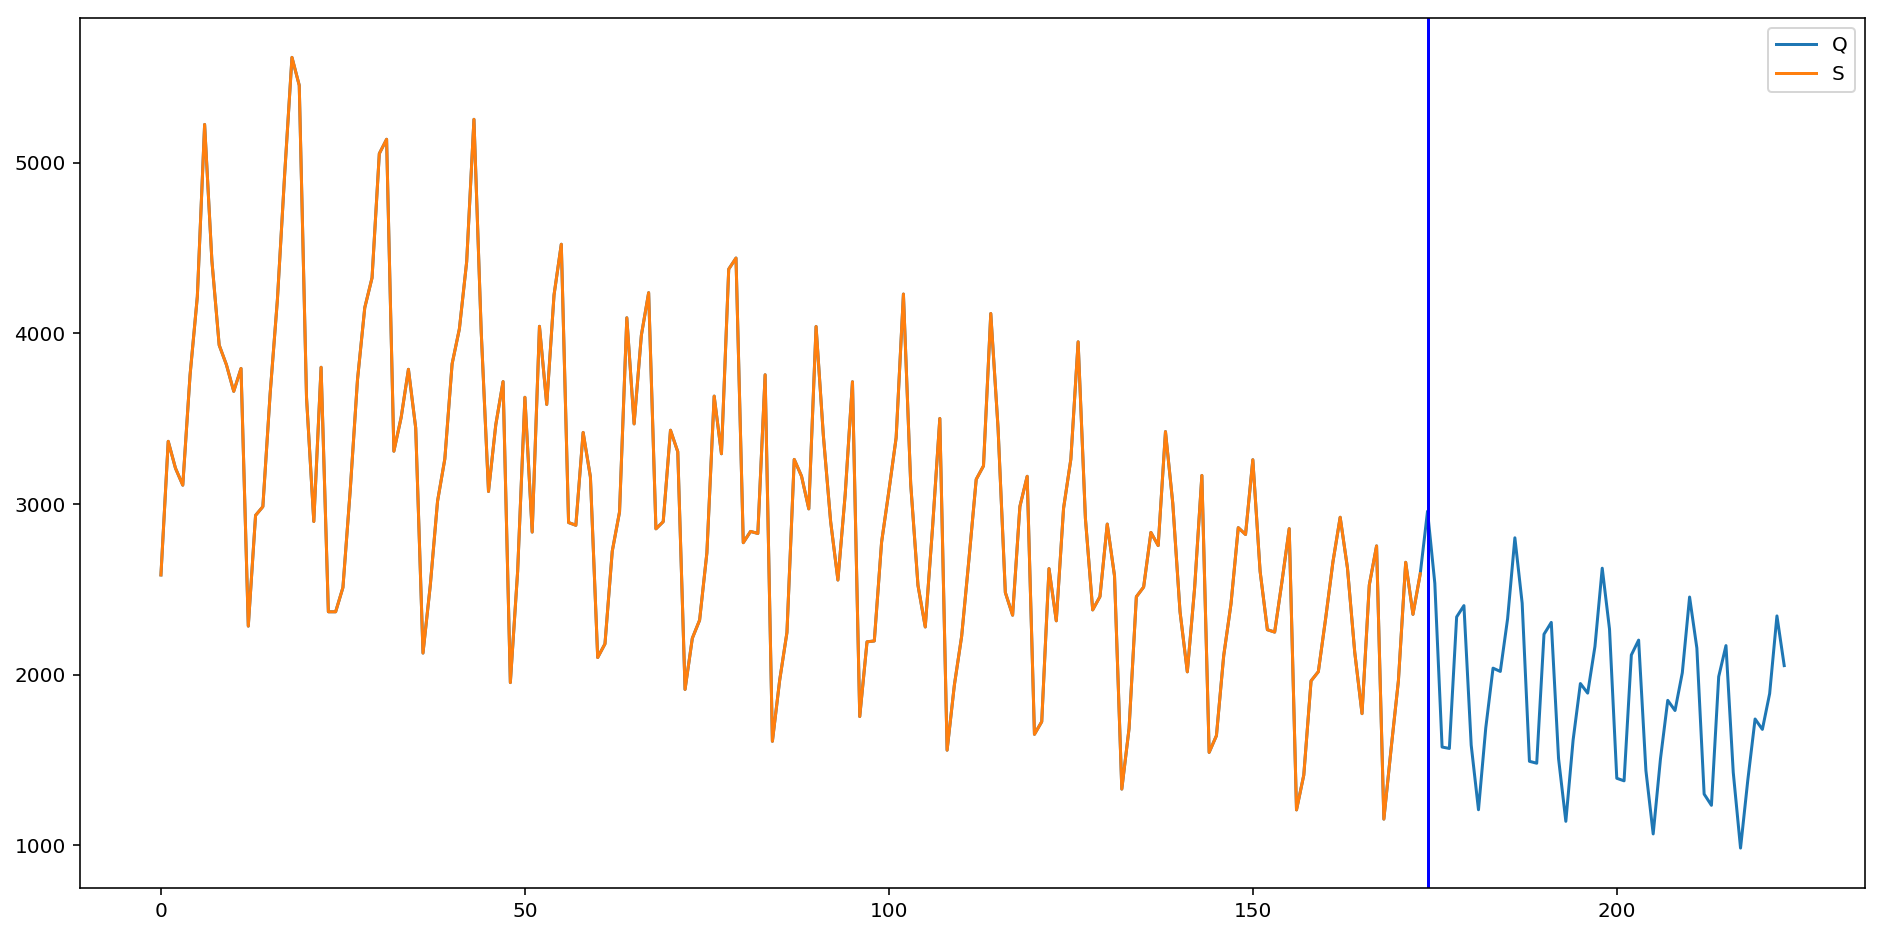

In [90]:
M = 50
N = len(F)
N_part = N 
F_part = F[:N_part]
L = 84
I = [0,1,2,3,4,5,6]

Q = SSA_R(F_part, N_part, L, M, I)
plt.figure(figsize=(16, 8))
plt.plot(Q, label='Q')
#plt.plot(range(0, N_part), F_part, label='S')
plt.plot(F, label='S')
plt.axvline(N_part, color = 'b')
plt.legend()
plt.show()

## SSA_S

In [123]:
def SSA_S(F, N, L, M, I):
    for f_new in range(M):
        F = np.append(F, random.uniform(min(F), max(F)))
        while True:
            
            N = len(F)
            # шаг вложения + шаг сингулярного разложения
            A, U, V = SSA_modes(Q, L) 
            L = len(A)
            K = N - L + 1

            #шаг группировки
            V = V.transpose()
            Z = np.dot(U[:, I], V[I, :])

            #этап диагонального усреднения
            G = np.zeros(N)
            L_ = min(L, K)
            K_ = max(L, K)    
    
            for k in range(0, L_):
                for m in range(0, k + 1):
                    G[k] += Z[m][k-m]
                G[k] *= 1/(k+1)
            for k in range(L_, K_):
                for m in range(0, L_):    
                    G[k] += Z[m][k-m]   
                G[k] *= 1/L_
            for k in range(K_, N):
                for m in range(k-K_+1, N-K_+1):
                    G[k] += Z[m][k-m]
                G[k] *= 1/(N-k)

            
            
            if round(F[-1], 3) - round(G[-1], 3) == 0:
                break
            else:
                F[-1] = G[-1]
    return F

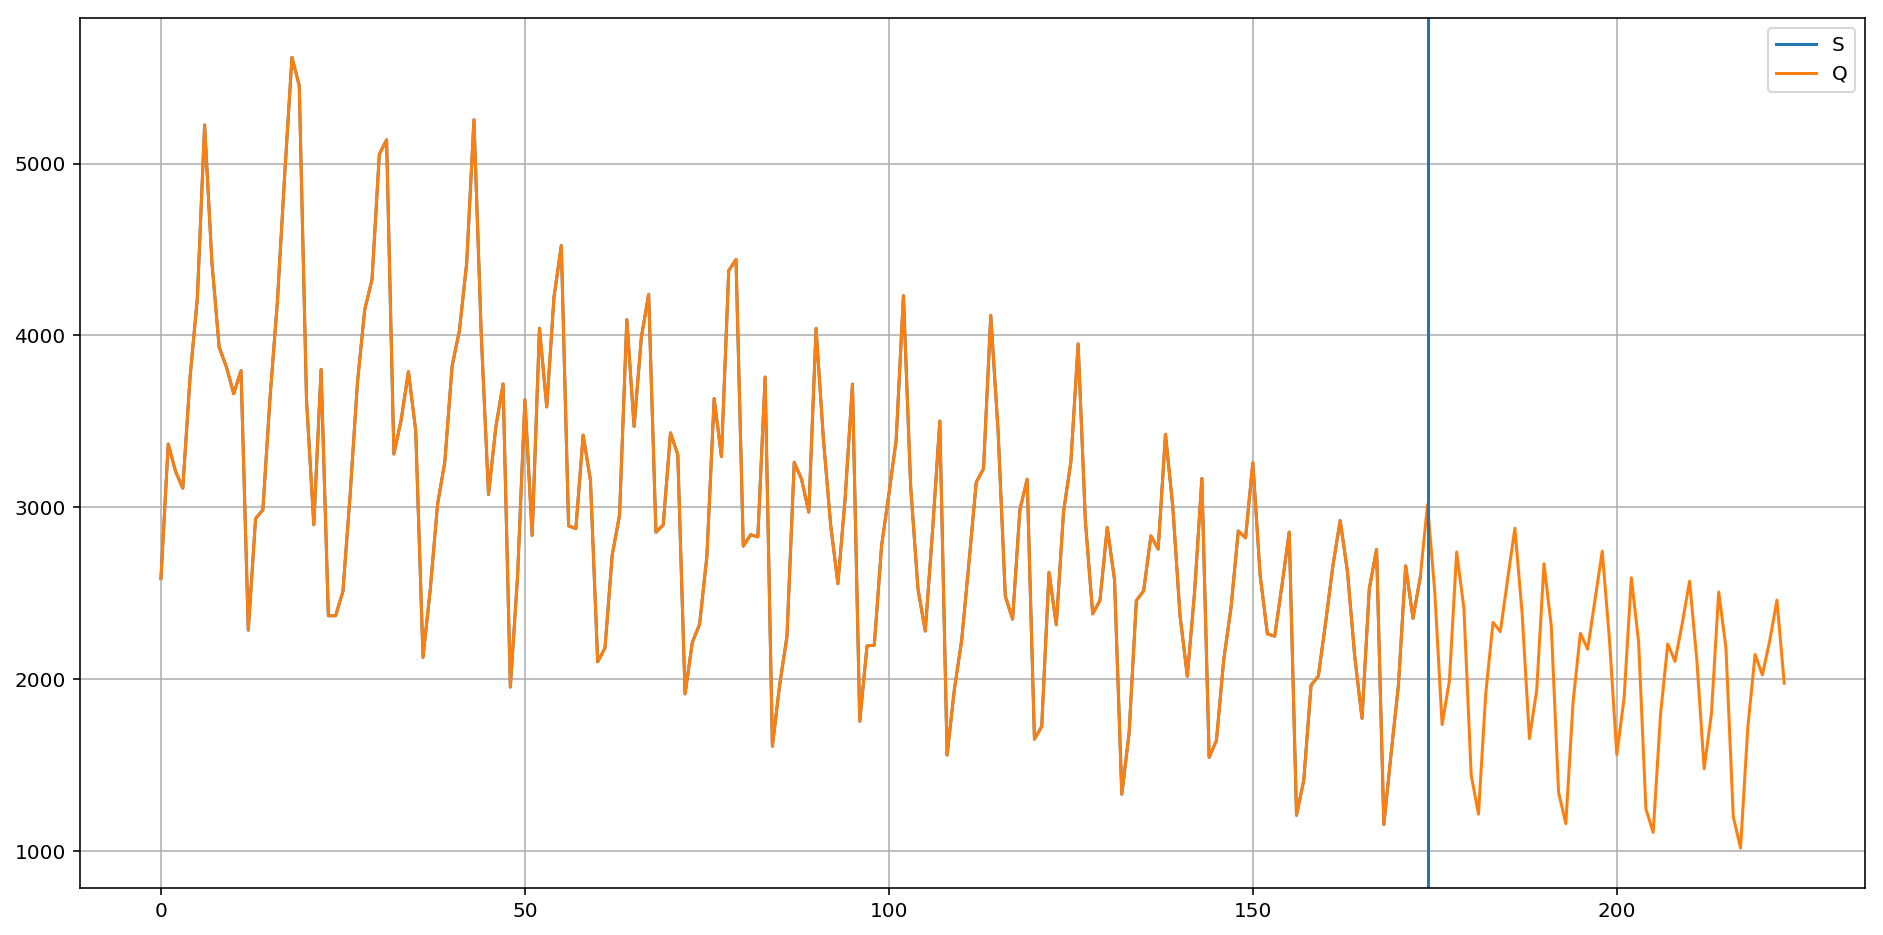

In [104]:
M = 50
N = len(F)
N_part = N 
F_part = F[:N_part]
L = 84
I = [0,1,2,3,4,5,6]

Q = SSA_S(F_part, N_part, L, M, I)
plt.figure(figsize=(16, 8))
plt.plot(F, label = 'S')
plt.plot(Q, label = 'Q')
plt.axvline(N_part)
plt.grid()
plt.legend()
plt.show()